**Machine Learning for prediction of the RMSD (Root Mean Square Deviation) of a decoy set using Physicochemical Properties of Protein Tertiary Structure Data Set**

The workflow followed here is adapted from the book [Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow](https://g.co/kgs/bvvihi) by **Aurélien Geron**.

*The dataset is downloaded from this link [Physicochemical Properties of Protein Tertiary Structure Data Set](https://archive.ics.uci.edu/ml/datasets/Physicochemical+Properties+of+Protein+Tertiary+Structure).* 

*This notebook is divided into two sections:*
1. **Data preprocessing** *- Explore the dataset and prepare it before regression*
2. **Model selection, training and fine tuning** *- Try with various models, compare their performance and fine tune them*

# 1. Data Preprocessing

Load all the relevant modules

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
plt.style.use('default')
%matplotlib inline

Download the dataset from UCI website and load using Pandas. In case the data exists already, load it directly without downloading

In [5]:
import requests, os

if os.path.exists("./CASP.csv") is False:
    r = requests.get("https://archive.ics.uci.edu/ml/machine-learning-databases/00265/CASP.csv", allow_redirects=True)
    open("CASP.csv", 'wb').write(r.content)
casp = pd.read_csv("CASP.csv")
casp.head()

,RMSD,F1,F2,F3,F4,F5,F6,F7,F8,F9
0,17.284,13558.30,4305.35,0.31754,162.1730,1.872791e+06,215.3590,4287.87,102,27.0302
1,6.021,6191.96,1623.16,0.26213,53.3894,8.034467e+05,87.2024,3328.91,39,38.5468
2,9.275,7725.98,1726.28,0.22343,67.2887,1.075648e+06,81.7913,2981.04,29,38.8119
3,15.851,8424.58,2368.25,0.28111,67.8325,1.210472e+06,109.4390,3248.22,70,39.0651
4,7.962,7460.84,1736.94,0.23280,52.4123,1.021020e+06,94.5234,2814.42,41,39.9147


Start with collecting all the useful statistics from the dataset

In [6]:
casp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45730 entries, 0 to 45729
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RMSD    45730 non-null  float64
 1   F1      45730 non-null  float64
 2   F2      45730 non-null  float64
 3   F3      45730 non-null  float64
 4   F4      45730 non-null  float64
 5   F5      45730 non-null  float64
 6   F6      45730 non-null  float64
 7   F7      45730 non-null  float64
 8   F8      45730 non-null  int64  
 9   F9      45730 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 3.5 MB


In [7]:
casp.describe()

,RMSD,F1,F2,F3,F4,F5,F6,F7,F8,F9
count,45730.000000,45730.000000,45730.000000,45730.000000,45730.000000,4.573000e+04,45730.000000,45730.000000,45730.000000,45730.000000
mean,7.748528,9871.596995,3017.367175,0.302392,103.492433,1.368299e+06,145.638061,3989.755990,69.975071,34.523664
std,6.118312,4058.138034,1464.324663,0.062886,55.424985,5.640367e+05,69.999230,1993.574575,56.493443,5.979755
min,0.000000,2392.050000,403.500000,0.092500,10.310100,3.194902e+05,31.970400,0.000000,0.000000,15.228000
25%,2.305000,6936.680000,1979.045000,0.258740,63.563900,9.535912e+05,94.757500,3165.322500,31.000000,30.424725
50%,5.030000,8898.805000,2668.155000,0.300150,87.740800,1.237219e+06,126.176000,3840.170000,54.000000,35.299300
75%,13.379000,12126.150000,3786.410000,0.342890,133.646750,1.690920e+06,181.468500,4644.192500,91.000000,38.870800
max,20.999000,40034.900000,15312.000000,0.577690,369.317000,5.472011e+06,598.408000,105948.170000,350.000000,55.300900


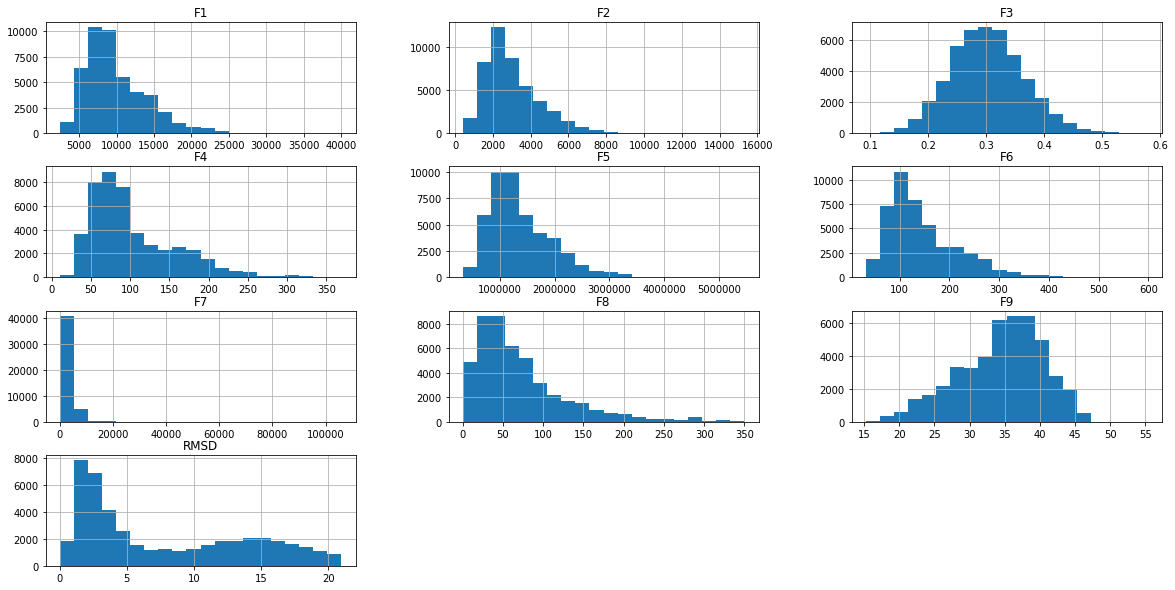

In [8]:
casp.hist(bins=20, figsize=(20,10));

One thing we notice is that, `F7` has tail heavy distribution. Let us see if there is any missing data in the dataset

In [9]:
np.any(casp.values == np.nan)

False

Generate the Standard Correlation Coefficient plot to visualize how every variable correlates with one another and at the same time with the target variable, `RMSD`

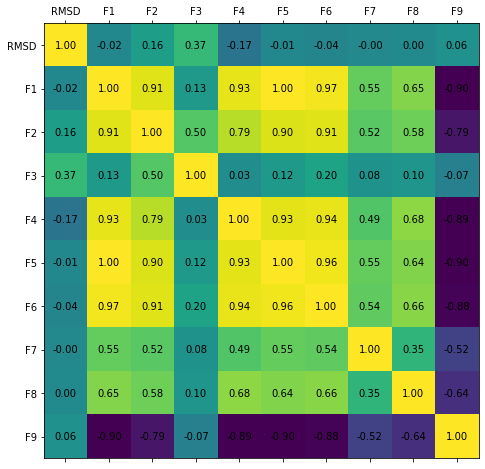

In [10]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
cax = ax.matshow(casp.corr(), interpolation='none')

for (i, j), value in np.ndenumerate(casp.corr()):
    plt.text(i, j, f"{value:.2f}", va="center", ha="center")

ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
ax.set_xticklabels(['']+list(casp));
ax.set_yticklabels(['']+list(casp));

Sort the linear correlation coefficient for `RMSD` to check which variables are correlated most with `RMSD`

In [11]:
casp.corr()['RMSD'].sort_values(ascending=False)

RMSD    1.000000
F3      0.374309
F2      0.156895
F9      0.062830
F8      0.000344
F7     -0.003339
F5     -0.013982
F1     -0.015087
F6     -0.036135
F4     -0.169771
Name: RMSD, dtype: float64

Turns out `F3` is very strongly correlated with `RMSD`. One thing to note here, this captures purely linear correlation and misses out the non linear correlation. Another method to visualize the correlation is scatter matrix

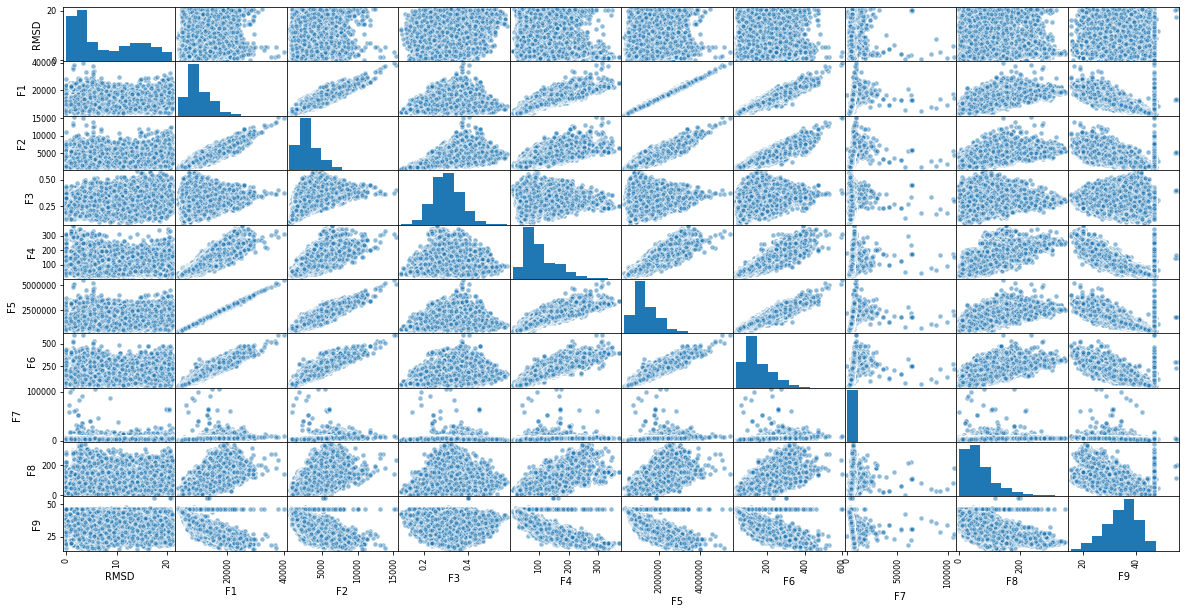

In [12]:
pd.plotting.scatter_matrix(casp, figsize=(20,10), edgecolors='w', s=100);

Some points to note from the plots above:

1. There is no strong linear correlation between independent variables and `RMSD`
2. Some of the features are very well correlated with each other. For example, `F1`, `F2`, `F4`, `F5` and `F6` seems to be correlated well. It is worthwhile to spend time in reducing the dimensionality of this data
3. From the correlations plots, let us pay more attention to feature `F9`. It can be easily noted that the values near ~50 have been capped artificially. Similarly For `RMSD`, the data is artificially capped close to 0.1. It is suggested to take a closer look at the data collection method. At this point, it is good to get rid of this data

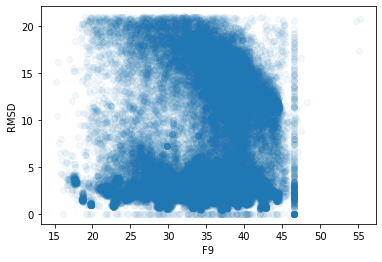

In [13]:
plt.scatter(casp["F9"], casp["RMSD"], alpha=0.05);
plt.xlabel("F9");
plt.ylabel("RMSD");

Let us for now get rid of this artificially capped data from the dataset

In [14]:
casp_cleaned = casp[casp['F9']<46]
casp_cleaned = casp_cleaned[casp_cleaned["RMSD"] > 0.1]
casp_cleaned = casp_cleaned.reset_index().drop("index", axis=1)

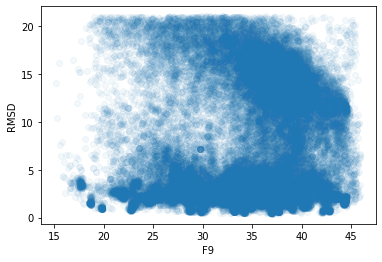

In [15]:
plt.scatter(casp_cleaned["F9"], casp_cleaned["RMSD"], alpha=0.05);
plt.xlabel("F9");
plt.ylabel("RMSD");

Seperate training set and test set from the CASP dataset. In this example, we will make use of stratified sampling for training and test set seperation. In this case, we pick `F3` for creating the categories since it correlates with `RSMD` the highest. Suppose, we are told that any other variable is important from the standpoint of retaining the same statistics for the test set as that of train set, we would use that variable to create the categories and sample the dataset from. In this case, start with having 6 categories of `F3` data

In [16]:
casp_cleaned["F3_cat"] = pd.cut(casp_cleaned["F3"], 
                                bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, np.inf],
                                labels = [1, 2, 3, 4, 5, 6])

Count the proportion of values corresponding to each category in `F3`

In [17]:
casp_cleaned["F3_cat"].value_counts()/len(casp_cleaned)

3    0.451977
4    0.435600
5    0.065732
2    0.044472
6    0.002153
1    0.000067
Name: F3_cat, dtype: float64

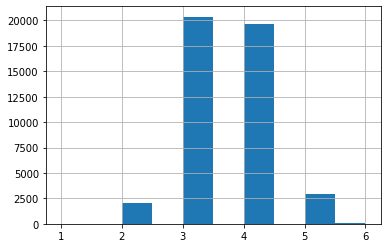

In [18]:
casp_cleaned["F3_cat"].hist()

In [19]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(casp_cleaned, casp_cleaned["F3_cat"]):
    casp_train_set = casp_cleaned.loc[train_index]
    casp_test_set = casp_cleaned.loc[test_index]

It appears that the category counts for training set of `L3` is matching with the original dataset

In [20]:
casp_train_set["F3_cat"].value_counts()/len(casp_train_set)

3    0.451968
4    0.435602
5    0.065744
2    0.044467
6    0.002164
1    0.000055
Name: F3_cat, dtype: float64

In [21]:
for set_ in (casp_train_set, casp_test_set):
    set_.drop("F3_cat", axis=1, inplace = True)

Separate the dependent and independent variables

In [22]:
X_train, y_train = casp_train_set.drop("RMSD", axis=1),casp_train_set["RMSD"]
X_test, y_test = casp_test_set.drop("RMSD", axis=1),casp_test_set["RMSD"]

As a last step, scale the variables of the input data using StandardScaler function. As we had noted earlier, the inputs are correlated with one another. Use PCA to project the inputs onto an independent bases. It will make model learning more efficient. Use 0.99 for `n_components` hyperparameter and let the algorithm find out how many number of independent bases it takes to reconstruct the inputs such that, 99% variance is recovered.

Combine these two operations using Pipeline module. Notice we will only scale the inputs, the outputs remain untouched

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipeline = Pipeline([
    ('std_scaler',StandardScaler()),
    ('pca', PCA(n_components=0.99))
])

X_train_scaled = pipeline.fit_transform(X_train)

# 2. Model selection, training and fine tuning

Start with linear regression, although we know that this will not be the best model, given there is no linear correlation between inputs and output. Linear regression model can be used as a good baseline model to compare other models with

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lin_reg = LinearRegression();

lin_reg.fit(X_train_scaled, y_train)

LinearRegression()

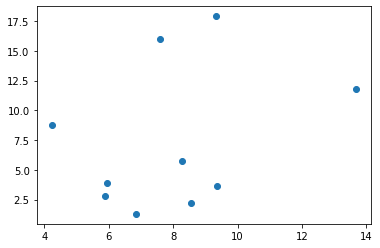

In [87]:
r = np.random.RandomState(42)
indices = r.choice(X_train_scaled.shape[0], 10)
X_selected = X_train_scaled[indices]
y_selected = y_train.values[list(indices)]

plt.scatter(lin_reg.predict(X_selected), y_selected)

Let us use the random forest regression model for this problem and see if that is better in terms of prediction accuracy

In [74]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(X_train_scaled, y_train);

In [75]:
scores= cross_val_score(forest_reg, X_train_scaled, y_train, scoring = "neg_mean_squared_error", cv=5)

NameError: name 'cross_val_score' is not defined

In [ ]:
display_scores(np.sqrt(-scores))

The random forest model is definitely better than linear regression model. Let us try to refine the model using Grid Search method

In [32]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'n_estimators': [2, 5, 10]},
              {'bootstrap': [False], 'n_estimators': [2, 5, 10]}]
forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=3,scoring='neg_mean_squared_error',return_train_score=True)

In [33]:
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid=[{'n_estimators': [2, 5, 10]},
                         {'bootstrap': [False], 'n_estimators': [2, 5, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [34]:
grid_search.best_estimator_

RandomForestRegressor(n_estimators=10)

In [35]:
results = grid_search.cv_results_
for mean_scores, params in zip(results["mean_test_score"], results["params"]):
    print(np.sqrt(-mean_scores), params)

4.920536778304008 {'n_estimators': 2}
4.341744856997106 {'n_estimators': 5}
4.1310498611994 {'n_estimators': 10}
5.440339193356122 {'bootstrap': False, 'n_estimators': 2}
5.393614312688876 {'bootstrap': False, 'n_estimators': 5}
5.378290338828119 {'bootstrap': False, 'n_estimators': 10}


In [36]:
best_model = grid_search.best_estimator_
best_model

RandomForestRegressor(n_estimators=10)

### Try with Neural Network

Let us also try and see if we can fit a neural network to this dataset.

In [39]:
from sklearn.neural_network import MLPRegressor

mlp_regressor = MLPRegressor(hidden_layer_sizes=(100,10),tol=1e-3, 
                             max_iter=1000, 
                             random_state=42, 
                             learning_rate_init=5e-4, 
                             learning_rate='adaptive',
                             validation_fraction=0.3,
                             early_stopping=True)

In [40]:
mlp_regressor.fit(X_train_scaled, y_train)

MLPRegressor(early_stopping=True, hidden_layer_sizes=(100, 10),
             learning_rate='adaptive', learning_rate_init=0.0005, max_iter=1000,
             random_state=42, tol=0.001, validation_fraction=0.3)

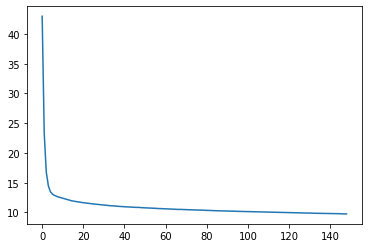

In [41]:
plt.plot(mlp_regressor.loss_curve_)